In [1]:
#!/usr/bin/env python

Demo: trinidi.reconstruct Module
==================================

This script illustrates the functionality of the `trinidi.reconstruct` submodule.

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from trinidi import cross_section, reconstruct, resolution, simulate, util

Generation of Simulated data
----------------------------
To generate the simulated data we use `trinidi`'s `generate_sample_data` function that generates
a phantom of overlapping discs of different isotopes and the associated measurement counts.

Below we define what isotopes to use for the phantom and what their corresponding densities, `z`
should become. The `projection_shape` is 2D and is the the size of the detector, but in general it
can be of any dimensionality.

In [3]:
isotopes = ["U-238", "Pu-239", "Ta-181"]
z = np.array([[0.005, 0.003, 0.004]]).T


# projection_shape = (16, 16) # use this for fast execution
projection_shape = (64, 64)  # use this for the docs

(
    Y_o,
    Y_s,
    ground_truth_params,
    Z,
    t_A,
    flight_path_length,
    N_b,
    kernels,
) = simulate.generate_sample_data(
    isotopes, z, acquisition_time=10, projection_shape=projection_shape
)

The arrays `Y_o` and `Y_s` contain the the open beam and sample neutron count measurements. The
first (two) axes correspond to `projection_shape`, which in most cases is equal to the detector
shape. The last axis correponds to the time-of-arrival (TOA) dimension which has `N_A` bins.

In [4]:
N_A = Y_o.shape[-1]

print(f"{Y_o.shape = }     (Open beam measurement)")
print(f"{Y_s.shape = }     (Sample measurement)")
print(f"{projection_shape = }     (Shape of the detector)")
print(f"{N_A = }     (Number of TOA bins)")

Y_o.shape = (64, 64, 365)     (Open beam measurement)
Y_s.shape = (64, 64, 365)     (Sample measurement)
projection_shape = (64, 64)     (Shape of the detector)
N_A = 365     (Number of TOA bins)


The corresponding array of TOAs (`t_A`) is in units of [μs] and has `N_A` elements.

In [5]:
print(f"t_A = [{t_A[0]:.2f}, {t_A[1]:.2f}, ..., {t_A[-2]:.2f}, {t_A[-1]:.2f}] [μs]")
print(f"{t_A.shape = }     (Same as N_A)")

t_A = [72.00, 72.90, ..., 398.70, 399.60] [μs]
t_A.shape = (365,)     (Same as N_A)


The `flight_path_length` has units of [m] and relates the neutron times with the neutron energies.
Below we illustrate the conversion from time to energy.

In [6]:
print(f"{flight_path_length = } [m]")
E = util.time2energy(t_A, flight_path_length)
print(f"E = [{E[0]:.2f}, {E[1]:.2f}, ..., {E[-2]:.2f}, {E[-1]:.2f}] [eV]")

flight_path_length = 10 [m]
E = [100.83, 98.36, ..., 3.29, 3.27] [eV]


The ground truth areal densities `Z` are used in order to later compare to our estimates. `Z` has
the same `projection_shape` as the measurements. The last axis of `Z` is the number of isotopes,
`N_m`.

In [7]:
N_m = Z.shape[-1]

print(f"{Z.shape = }     (Ground truth areal densities)")
print(f"{N_m = }     (Number of isotopes)")
print(f"{len(isotopes) = }     (Also number of isotopes))")

Z.shape = (64, 64, 3)     (Ground truth areal densities)
N_m = 3     (Number of isotopes)
len(isotopes) = 3     (Also number of isotopes))


We can show the areal densities `Z` using the plotting function below.

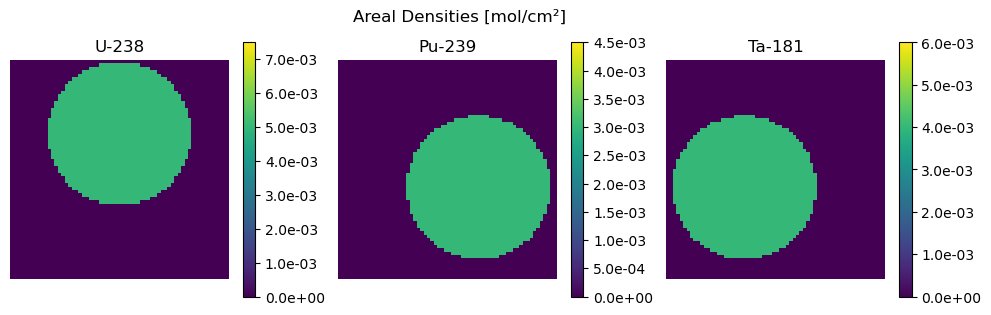

In [8]:
def plot_densities(Z, isotopes, vmaxs=None):
    r"""Show areal densities. `ax` must be list."""

    fig, ax = plt.subplots(1, len(isotopes), figsize=[12, 3.3])
    ax = np.atleast_1d(ax)

    for i, isotope in enumerate(isotopes):
        z = Z[:, :, i]
        if vmaxs is None:
            vmax = np.percentile(z, 99.9)
        else:
            vmax = vmaxs[i]
        vmin = 0
        im = ax[i].imshow(z, vmin=vmin, vmax=vmax)
        fig.colorbar(im, ax=ax[i], format="%.1e")
        ax[i].set_title(f"{isotope}")
        ax[i].axis("off")

    fig.suptitle("Areal Densities [mol/cm²]")

    return fig, ax


plot_densities(Z, isotopes, vmaxs=z * 1.5)
plt.show()

As shown above, the phantom consists of several discs and the `i`th disc corresponds to
`isotopes[i]` which has density `z[i]`, so it is equal to `Z[:,:,i].max()`.

In [9]:
for i, (iso, z_i) in enumerate(zip(isotopes, z.flatten())):
    print(f"{iso}: {z_i} = ({Z[:,:,i].max()}) [mol/cm²]")

U-238: 0.005 = (0.005) [mol/cm²]
Pu-239: 0.003 = (0.003) [mol/cm²]
Ta-181: 0.004 = (0.004) [mol/cm²]


Preparation for the Reconstruction
----------------------------------

For the reconstruction we need to define the regions `Ω_z` and `Ω_0` that correspond to the so
called uniformly dense region and the open beam region, respectively.

For this we use the `ProjectionRegion` class. We initialize each with a mask (boolean array) that
has shape `projection_shape + (1,)`, indicating which pixels belong to these regions.

In this example we use the ground truth `Z` to find these regions as
 - the overlap of all discs: Ω_z
 - the complement of the union of all discs: Ω_0.

(In the general case when the ground truth is not known, the user will have to find a way to define
these regions such as through prior knowledge about where to adequately find such regions.)

In [10]:
mask_z = np.prod(Z, axis=2, keepdims=True) > 0
Ω_z = reconstruct.ProjectionRegion(mask_z)

mask_0 = np.sum(Z, axis=2, keepdims=True) == 0
Ω_0 = reconstruct.ProjectionRegion(mask_0)

print(f"mask_z.shape = mask_0.shape = {mask_0.shape}")

mask_z.shape = mask_0.shape = (64, 64, 1)


We can illustrate these regions using the `ProjectionRegion.plot_contour` and the
`ProjectionRegion.imshow` functions below.

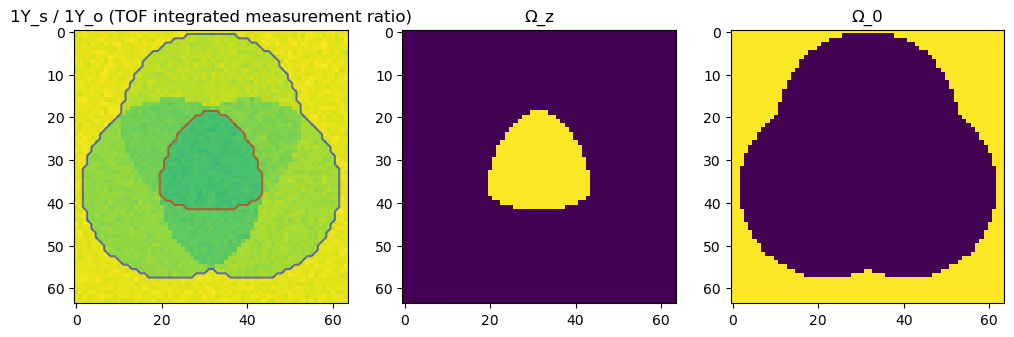

In [11]:
fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax = np.atleast_1d(ax)

ax[0].imshow(np.sum(Y_s, axis=-1) / np.sum(Y_o, axis=-1), vmin=0)
ax[0].set_title("1Y_s / 1Y_o (TOF integrated measurement ratio)")
Ω_z.plot_contours(ax[0], color="red")
Ω_0.plot_contours(ax[0], color="blue")

Ω_z.imshow(ax[1], title="Ω_z")
Ω_0.imshow(ax[2], title="Ω_0")

plt.show()

Next we need to define the resolution operator, `R`. We use the same `kernels` used for the
generation of the data to initialize the `ResolutioOperator` object.

In [12]:
R = resolution.ResolutionOperator(Y_s.shape, t_A, kernels=kernels)
print(R)

<class 'trinidi.resolution.ResolutionOperator'>
    input_shape = (64, 64, 367) = projection_shape + (N_F,)
    output_shape = (64, 64, 365) = projection_shape + (N_A,)

    projection_shape = (64, 64)
    N_F = 367
    N_A = 365
        


Since the resolution operator inputs wider spectra than it outputs, there is an additional vector
of time-of-flights (TOF), `t_F`, with size `N_F`, associated with the input times. The `t_F` array
is calibrated such that approximately R(t_A) = t_F.

In [13]:
t_F = R.t_F
N_F = t_F.size

print(f"{N_A = }")
print(f"t_A = [{t_A[0]:.2f}, {t_A[1]:.2f}, ..., {t_A[-2]:.2f}, {t_A[-1]:.2f}] [μs]")
print(f"{N_F = }")
print(f"t_F = [{t_F[0]:.2f}, {t_F[1]:.2f}, ..., {t_F[-2]:.2f}, {t_F[-1]:.2f}] [μs]")

N_A = 365
t_A = [72.00, 72.90, ..., 398.70, 399.60] [μs]
N_F = 367
t_F = [71.10, 72.00, ..., 400.05, 400.95] [μs]


The cross section dictionary uses `t_F` as calibration for the neutron energies. Below we define
the `XSDict` object.

In [14]:
D = cross_section.XSDict(isotopes, t_F, flight_path_length)
print(D)

<class 'trinidi.cross_section.XSDict'>
    isotopes = ['U-238', 'Pu-239', 'Ta-181']
    N_m = 3

    t_F = [71.099 μs, ..., 400.951 μs]
    Δt = 0.901 μs
    N_F = 367
    flight_path_length = 10.000 m
    E = [103.401 eV, ..., 3.251 eV]

    samples_per_bin = 10

    values.shape = (3, 367) = (N_m, N_F)
        


Below we plot the average measurements in the `Ω_z` and `Ω_0` regions compared to the cross section
dictionary. We use the `ProjectionRegion.averge` function to compute these average spectra.

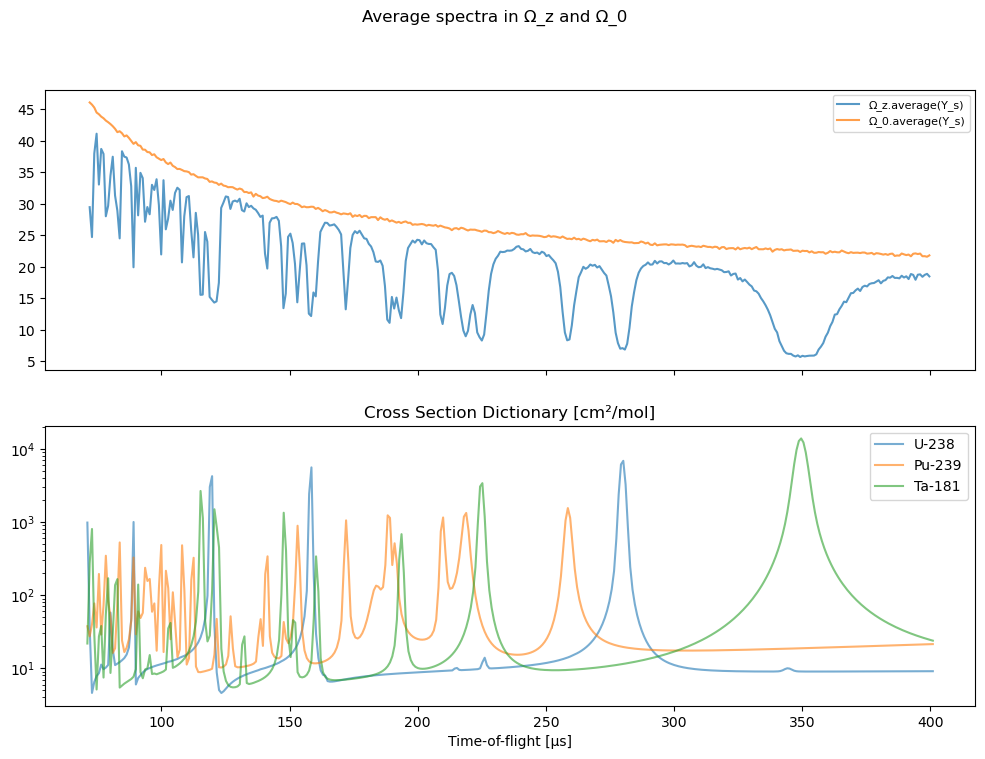

In [15]:
fig, ax = plt.subplots(2, 1, figsize=[12, 8], sharex=True)
ax = np.atleast_1d(ax)
ax[0].plot(t_A, Ω_z.average(Y_s).flatten(), label="Ω_z.average(Y_s)", alpha=0.75)
ax[0].plot(t_A, Ω_0.average(Y_s).flatten(), label="Ω_0.average(Y_s)", alpha=0.75)
D.plot(ax[1])
ax[0].legend(prop={"size": 8})
fig.suptitle("Average spectra in Ω_z and Ω_0")
plt.show()

Reconstruction of the Nuisance Parameters
-----------------------------------------
The nuisance parameters are computed first before the densities can be computed. They parametrize
such quantities associated the the neutron flux and background at every pixel (Φ, B) and global
scalers such as the overall relative exposure and sample induced background factors (α_1, α_2). We
do not expect the general user to need to understand these parameters intricately and thus the
handling of these parameters is encapsulated inside the `ParameterEstimator` object.

Below we define a `ParameterEstimator` object. For the background we use the same number `N_b` of
basis functions as used for the simulation. This estimates the nuisance parameters
(z, α_1, α_1, θ) using the relatively fast `BFGS` algorithm.

In [16]:
par = reconstruct.ParameterEstimator(Y_o, Y_s, R, D, Ω_z, Ω_0=Ω_0, N_b=N_b)

`Advanced users:` The parameters are available through the `ParameterEstimator.get` function. They
can manually be modified using the `ParameterEstimator.set` function. We also provide similar
`save` and `load` functions to write/read them to file.

In [17]:
d = par.get()
print(d)


par.set(**d)
par.set(z=d["z"], α_1=d["α_1"], α_2=d["α_2"], θ=d["θ"])  # same as line above

# par.save("par.npy")
# d = par.load("par.npy")

{'z': array([[0.0050716 ],
       [0.00298903],
       [0.00397148]]), 'α_1': 1.1998651350513319, 'α_2': 0.800817361373174, 'θ': array([[46.6562122 ],
       [-8.7921481 ],
       [ 0.32151884]])}


Once the `ParameterEstimator` object has been constructed we can plot the `Ω_z` and `Ω_0` regions
much more easily than above using the `ParameterEstimator.plot_regions` function.

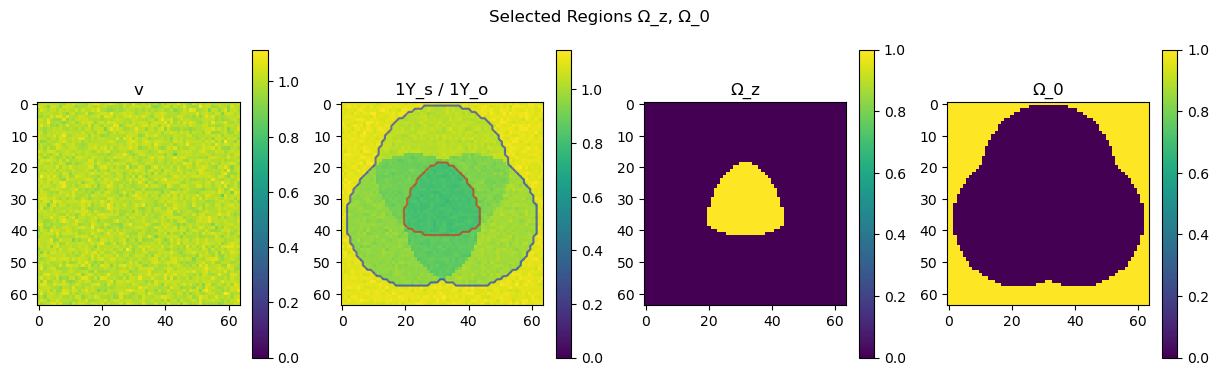

In [18]:
par.plot_regions()
plt.show()

The `ParameterEstimator.plot_results` function allows to display the resulting spectra from the
estimation and verify good fitting of the signals.

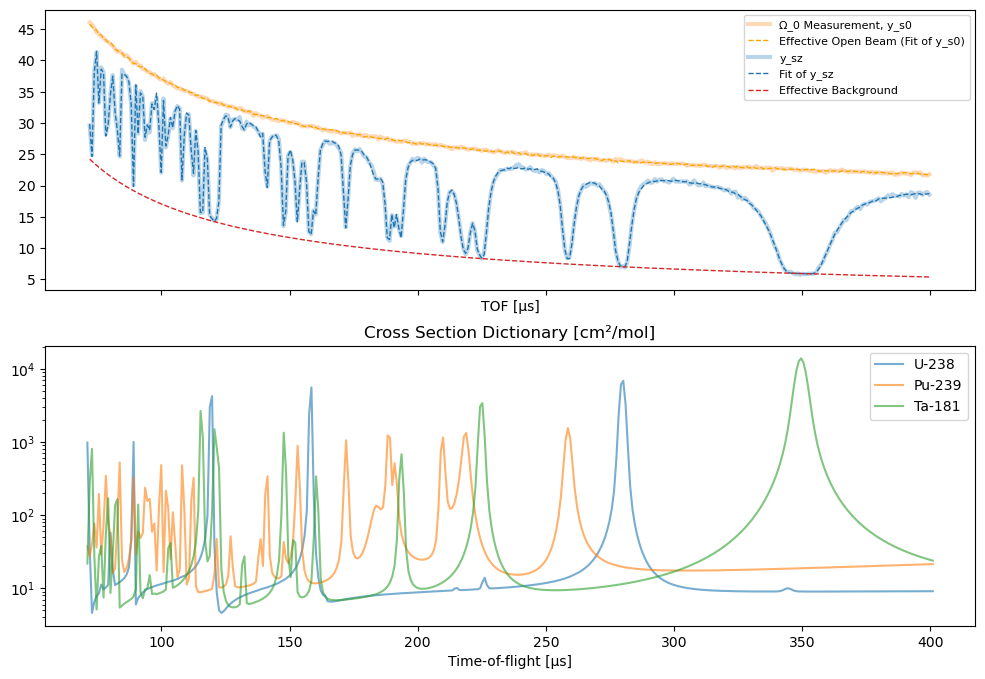

In [19]:
par.plot_results()
plt.show()

We also provide the APGM optimization routine used in our paper, however we do not recommend it
since tends to be signicicantly slower.

In [20]:
# par.apgm_solve(iterations=100)
# fig, ax = par.apgm_plot_convergence(plot_residual=True, ground_truth=ground_truth_params)
# plt.show()

Reconstruction of the Areal Densities
-------------------------------------
Now that the nuisance parameters have been computed and stored in the `ParameterEstimator` object,
we can carry on with the main task, i.e. with the areal density reconstruction.

We define a `DensityEstimator` object. Note that if the optional arguments `D` and `R` are left
empty, the `D` and `R` operators from the `par` `Parameters` object will be used for the
reconstruction.

(If different `D` and `R` operators are desired, they need to be passed to the `DensityEstimator`
constructor.)

In [21]:
den = reconstruct.DensityEstimator(Y_s, par, non_negative_Z=False, dispperiod=50)

We reonstruct the areal densities using the `DensityEstimator.solve` function which returns the
areal density estimates `Z_hat`.

In [22]:
Z_hat = den.solve(iterations=200)

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  6.78e+00  2.441e+06  4.719e+00  3.075e+02
  50  1.91e+01  2.248e+06  6.226e+00  4.353e+01
 100  3.13e+01  2.238e+06  4.107e+00  2.731e+01
 150  4.36e+01  2.238e+06  5.418e+00  6.982e+00
 199  5.57e+01  2.238e+06  7.943e+00  4.495e+00


We can plot the convergence of the objective using the `DensityEstimator.plot_convergence`
function. The ground truth argument is optional and will additionaly display the objective to the
ground truth.

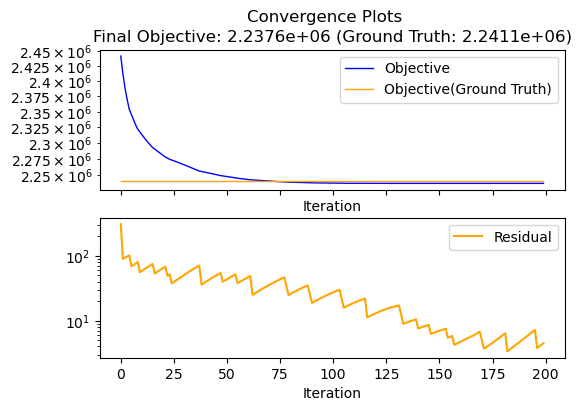

In [23]:
den.plot_convergence(ground_truth=Z)
plt.show()

We use this plotting function below to plot the resulting areal density estimates and compare them
to the ground truth (`Z`)

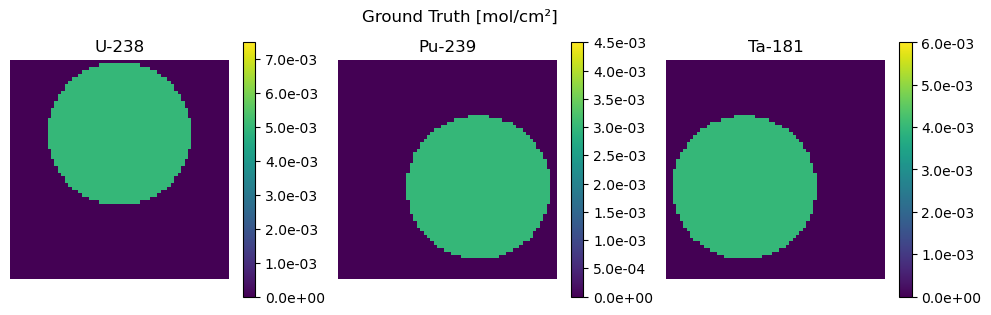

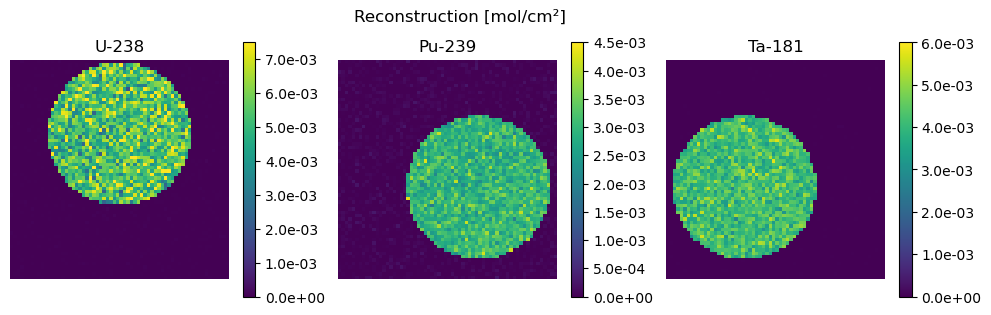

In [24]:
def plot_compare(Z, str_Z, Z_hat, str_Z_hat):
    r"""Generate two plots comparing ground truth with reconstruction."""
    fig, ax = plot_densities(Z, isotopes, vmaxs=z * 1.5)
    fig.suptitle(f"{str_Z} [mol/cm²]")

    fig, ax = plot_densities(Z_hat, isotopes, vmaxs=z * 1.5)
    fig.suptitle(f"{str_Z_hat} [mol/cm²]")


plot_compare(Z, "Ground Truth", Z_hat, "Reconstruction")
plt.show()

Cropped or Binned Measurements
------------------------------

In practice, it is not always desired to reconstruct the full field of view or at full resolution:
Perhaps we require the full field of view to estimate the nuisance parameters, but
we only want to reconstruct a small cropped region.
For this reason we can provide the `projection_transform` argument in the `DensityEstimator`
constructor.

The `projection_transform` is the desired operation that is applied to the measurements and used
internally to handle the modification of the background and flux estimates.

First we show an example of binned data using the below defined `binning_2x2` function.

In [25]:
def binning_2x2(Y):
    r"""Bin an array of shape (N, M, ...) with the result being (N//2, M//2, ...)"""
    N0 = Y.shape[0] // 2
    N1 = Y.shape[1] // 2
    Y = Y[0::2][:N0] + Y[1::2][:N0]
    Y = Y[:, 0::2][:, :N1] + Y[:, 1::2][:, :N1]
    return Y

We define the `DensityEstimator` but pass the `binning_2x2` as the `projection_transform` argument
and use `solve` as usual. Note that the resulting detector shape is half the size in each
direction.

In [26]:
den = reconstruct.DensityEstimator(
    Y_s, par, projection_transform=binning_2x2, non_negative_Z=False, dispperiod=50
)
den.solve(iterations=200)

Z_binned = binning_2x2(Z) / (2 * 2)  # over 4 to keep ground truth scale the same.
Z_hat_binned = den.Z

print(f"{Z.shape = }")
print(f"{Z_binned.shape = }")

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  2.29e+00  8.868e+05  1.887e+01  1.514e+02
  50  5.12e+00  6.991e+05  2.490e+01  2.021e+01
 100  7.97e+00  6.915e+05  3.286e+01  7.354e+00
 150  1.07e+01  6.916e+05  1.084e+01  2.844e+00
 199  1.36e+01  6.914e+05  1.589e+01  3.241e+00
Z.shape = (64, 64, 3)
Z_binned.shape = (32, 32, 3)


We plot the results below.

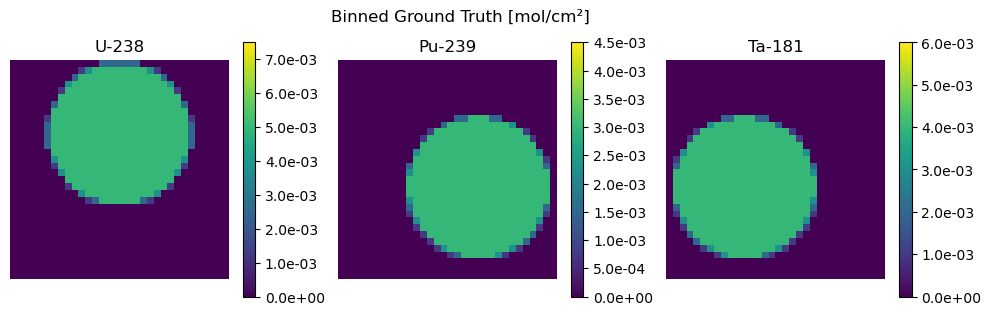

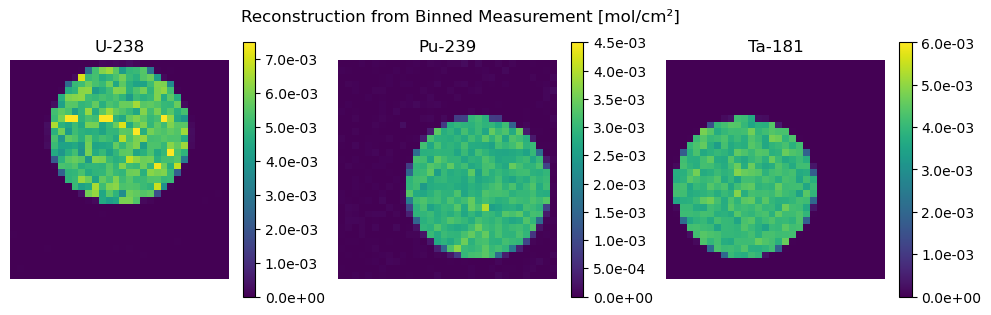

In [27]:
plot_compare(
    Z_binned, "Binned Ground Truth", Z_hat_binned, "Reconstruction from Binned Measurement"
)
plt.show()

Second we show an example of cropping data using the below defined `crop` function.

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  2.59e+00  8.262e+05  4.719e+00  2.456e+02
  50  6.07e+00  6.993e+05  6.226e+00  3.483e+01
 100  9.49e+00  6.930e+05  4.107e+00  2.249e+01
 150  1.30e+01  6.928e+05  5.418e+00  6.223e+00
 199  1.64e+01  6.928e+05  7.943e+00  3.730e+00
Z_crop.shape = (36, 36, 3)
Z.shape = (64, 64, 3)


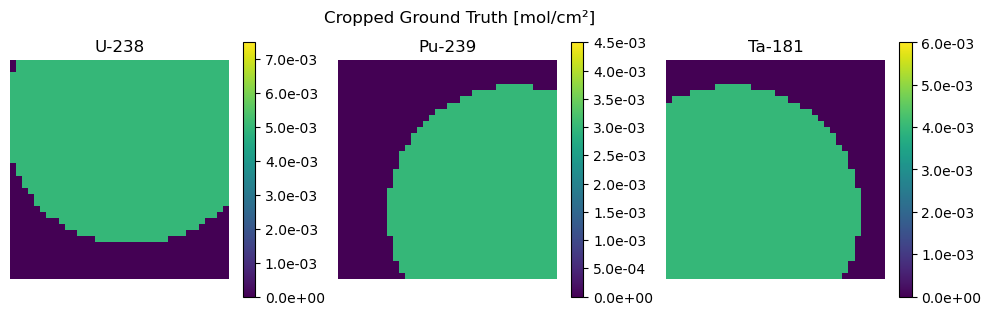

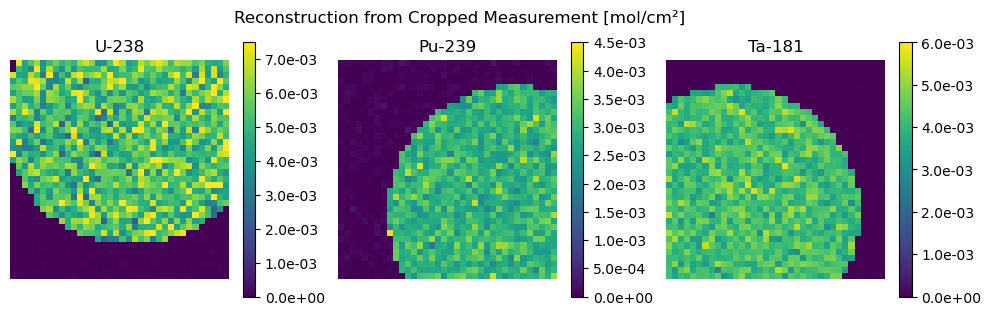

In [28]:
def crop(Y):
    r"""Create center crop from 1/5 to 4/5 of the FOV."""
    N0 = Y.shape[0] // 5
    N1 = Y.shape[1] // 5
    Y = Y[N0 : 4 * N0, N1 : 4 * N1]
    return Y


den = reconstruct.DensityEstimator(
    Y_s, par, projection_transform=crop, non_negative_Z=False, dispperiod=50
)
den.solve(iterations=200)

Z_crop = crop(Z)
Z_hat_crop = den.Z

print(f"{Z_crop.shape = }")
print(f"{Z.shape = }")


plot_compare(Z_crop, "Cropped Ground Truth", Z_hat_crop, "Reconstruction from Cropped Measurement")
plt.show()

If multiple transformations are required, those can easily be composed such as below.

In [29]:
projection_transform = lambda Y: crop(binning_2x2(Y))